# Absenteísmo em Teleconsultas - Sprint 4 IA


## 1. Import + Carregamento de dados (EDA)

Importamos as bibliotecas que serão utilizadas no notebook e carregamos todos os arquivos CSV do projeto, conferindo suas primeiras linhas para verificar a integridade e estrutura dos dados.

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [53]:
# Carregamento dos Dados

# Lista dos arquivos CSV a serem carregados
csv_files = [
    '/content/clinicians_enhanced.csv',
    '/content/appointments_combined.csv',
    '/content/patients_enhanced.csv',
    '/content/teleconsult_logs_enhanced.csv',
    '/content/appointments_enhanced.csv',
    '/content/reminders_enhanced.csv'
]

# Dicionário para armazenar os DataFrames
dataframes = {}

# Especificar dtypes para colunas problemáticas, se necessário, para evitar DtypeWarning
# Baseado no warning anterior, algumas colunas em 'appointments_combined.csv' podem precisar de atenção.
# Vou carregar com low_memory=False para tentar inferir melhor, mas se persistir,
# será necessário inspecionar os arquivos e especificar dtypes manualmente.
# Por enquanto, vamos tentar com low_memory=False.
for file in csv_files:
    df_name = file.split('/')[-1].replace('.csv', '')
    try:
        dataframes[df_name] = pd.read_csv(file, low_memory=False)
    except Exception as e:
        print(f"Erro ao carregar o arquivo {file}: {e}")
        # Se low_memory=False não resolver, pode ser necessário inspecionar o arquivo
        # e carregar com dtypes especificados.
        # Exemplo:
        # if df_name == 'appointments_combined':
        #     dtype_spec = {'coluna1': str, 'coluna2': float, ...}
        #     dataframes[df_name] = pd.read_csv(file, dtype=dtype_spec)
        # else:
        #     raise e # Re-raise other errors


# Exibir as primeiras linhas de cada DataFrame para verificação
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    display(df.head())

DataFrame: clinicians_enhanced


,clinician_id,specialty,years_experience
0,C2000,Cardiologia,38
1,C2001,Ortopedia,2
2,C2002,Clínica Geral,26
3,C2003,Psiquiatria,6
4,C2004,Endocrinologia,20


DataFrame: appointments_combined


,neighborhood,insurance_type,diagnosis_icd10,scheduledday,has_hypertension,socioeconomic_index,comorbidity_count,diabetes,has_chronic_resp,distance_km,...,scholarship,weather_rain,neighbourhood,sms_received,platform,reminder_sms,video_ok,hipertension,no_show_flag,age
0,NaN,NaN,NaN,2016-04-29 18:38:08+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,JARDIM DA PENHA,0.0,WhatsApp,1,1.0,1.0,No,62
1,NaN,NaN,NaN,2016-04-29 16:08:27+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,JARDIM DA PENHA,0.0,App HC,1,1.0,0.0,No,56
2,NaN,NaN,NaN,2016-04-29 16:19:04+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,MATA DA PRAIA,0.0,Portal HC,0,1.0,0.0,No,62
3,NaN,NaN,NaN,2016-04-29 17:29:31+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,PONTAL DE CAMBURI,0.0,WhatsApp,1,1.0,0.0,No,8
4,NaN,NaN,NaN,2016-04-29 16:07:23+00:00,NaN,NaN,NaN,1.0,NaN,NaN,...,0.0,NaN,JARDIM DA PENHA,0.0,WhatsApp,0,1.0,1.0,No,56


DataFrame: patients_enhanced


,patient_id,age,gender,neighborhood,socioeconomic_index,insurance_type,has_diabetes,has_hypertension,has_chronic_resp,comorbidity_count
0,P100000,58,F,Zona Norte,2,SUS (público),0,0,0,0
1,P100001,47,F,Zona Leste,3,SUS (público),1,0,0,1
2,P100002,61,M,Zona Norte,5,SUS (público),0,0,0,0
3,P100003,77,F,Zona Oeste,3,Convênio Privado,0,1,0,1
4,P100004,45,M,Periferia,4,Convênio Privado,0,0,0,0


DataFrame: teleconsult_logs_enhanced


,appointment_id,connected,connect_delay_min,actual_duration_min,video_ok,audio_ok,insurance_type
0,A309953,1,2.0,13,1,1,Convênio Privado
1,A303850,0,NaN,0,0,0,SUS (público)
2,A304962,1,3.0,35,1,1,SUS (público)
3,A303886,0,NaN,0,0,0,Particular (sem convênio)
4,A305437,1,0.0,13,0,1,SUS (público)


DataFrame: appointments_enhanced


,appointment_id,patient_id,clinician_id,appointment_date,appointment_time,day_of_week,hour_of_day,lead_time_days,specialty,is_first_visit,...,diagnosis_icd10,age,gender,neighborhood,socioeconomic_index,insurance_type,has_diabetes,has_hypertension,has_chronic_resp,comorbidity_count
0,A300000,P100806,C2094,2025-07-04,11:00,Friday,0,7,Clínica Geral,0,...,R51,53,F,Zona Oeste,3,SUS (público),0,0,0,0
1,A300001,P103070,C2077,2024-04-02,10:00,Tuesday,0,7,Neurologia,0,...,R05,27,M,Zona Oeste,5,Convênio Privado,0,0,0,0
2,A300002,P103373,C2100,2024-03-09,16:30,Saturday,0,11,Clínica Geral,0,...,R51,82,M,Centro,5,Convênio Privado,0,1,0,1
3,A300003,P100559,C2082,2024-03-10,8:00,Sunday,0,13,Dermatologia,1,...,L50,42,M,Zona Oeste,1,SUS (público),0,0,0,0
4,A300004,P102074,C2036,2025-02-03,12:30,Monday,0,6,Pediatria,0,...,H65,38,M,Zona Leste,4,Convênio Privado,0,1,0,1


DataFrame: reminders_enhanced


,appointment_id,patient_id,appointment_date,reminder_sms,reminder_call,reminder_email,notification_delay_hours,reminder_sent,insurance_type
0,A300000,P100806,2025-07-04,1,1,0,41,1,SUS (público)
1,A300001,P103070,2024-04-02,0,0,0,70,0,Convênio Privado
2,A300002,P103373,2024-03-09,1,0,0,110,1,Convênio Privado
3,A300003,P100559,2024-03-10,1,0,0,80,1,SUS (público)
4,A300004,P102074,2025-02-03,0,1,1,0,1,Convênio Privado


## 2. Análise Exploratória (EDA)

Vamos começar a Análise Exploratória de Dados para entender melhor a estrutura e o conteúdo dos nossos dataframes.

In [54]:
# Análise Exploratória (EDA)

# Função para exibir informações básicas de um DataFrame
def explore_dataframe(df, name):
    print(f"\n--- Explorando DataFrame: {name} ---")
    print("Informações Gerais:")
    df.info()
    print("\nPrimeiras 5 linhas:")
    display(df.head())
    print("\nEstatísticas Descritivas:")
    display(df.describe(include='all'))
    print("\nValores Nulos:")
    print(df.isnull().sum())
    print("\nForma do DataFrame (linhas, colunas):")
    print(df.shape)

# Explorar cada DataFrame carregado
for name, df in dataframes.items():
    explore_dataframe(df, name)


--- Explorando DataFrame: clinicians_enhanced ---
Informações Gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   clinician_id      120 non-null    object
 1   specialty         120 non-null    object
 2   years_experience  120 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ KB

Primeiras 5 linhas:


,clinician_id,specialty,years_experience
0,C2000,Cardiologia,38
1,C2001,Ortopedia,2
2,C2002,Clínica Geral,26
3,C2003,Psiquiatria,6
4,C2004,Endocrinologia,20



Estatísticas Descritivas:


,clinician_id,specialty,years_experience
count,120,120,120.000000
unique,120,9,NaN
top,C2000,Clínica Geral,NaN
freq,1,23,NaN
mean,NaN,NaN,19.441667
std,NaN,NaN,12.199873
min,NaN,NaN,1.000000
25%,NaN,NaN,9.500000
50%,NaN,NaN,17.000000
75%,NaN,NaN,30.000000



Valores Nulos:
clinician_id        0
specialty           0
years_experience    0
dtype: int64

Forma do DataFrame (linhas, colunas):
(120, 3)

--- Explorando DataFrame: appointments_combined ---
Informações Gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120527 entries, 0 to 120526
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   neighborhood               10000 non-null   object 
 1   insurance_type             10000 non-null   object 
 2   diagnosis_icd10            10000 non-null   object 
 3   scheduledday               110527 non-null  object 
 4   has_hypertension           10000 non-null   float64
 5   socioeconomic_index        10000 non-null   float64
 6   comorbidity_count          10000 non-null   float64
 7   diabetes                   110527 non-null  float64
 8   has_chronic_resp           10000 non-null   float64
 9   distance_km                10000 non-null

,neighborhood,insurance_type,diagnosis_icd10,scheduledday,has_hypertension,socioeconomic_index,comorbidity_count,diabetes,has_chronic_resp,distance_km,...,scholarship,weather_rain,neighbourhood,sms_received,platform,reminder_sms,video_ok,hipertension,no_show_flag,age
0,NaN,NaN,NaN,2016-04-29 18:38:08+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,JARDIM DA PENHA,0.0,WhatsApp,1,1.0,1.0,No,62
1,NaN,NaN,NaN,2016-04-29 16:08:27+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,JARDIM DA PENHA,0.0,App HC,1,1.0,0.0,No,56
2,NaN,NaN,NaN,2016-04-29 16:19:04+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,MATA DA PRAIA,0.0,Portal HC,0,1.0,0.0,No,62
3,NaN,NaN,NaN,2016-04-29 17:29:31+00:00,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,PONTAL DE CAMBURI,0.0,WhatsApp,1,1.0,0.0,No,8
4,NaN,NaN,NaN,2016-04-29 16:07:23+00:00,NaN,NaN,NaN,1.0,NaN,NaN,...,0.0,NaN,JARDIM DA PENHA,0.0,WhatsApp,0,1.0,1.0,No,56



Estatísticas Descritivas:


,neighborhood,insurance_type,diagnosis_icd10,scheduledday,has_hypertension,socioeconomic_index,comorbidity_count,diabetes,has_chronic_resp,distance_km,...,scholarship,weather_rain,neighbourhood,sms_received,platform,reminder_sms,video_ok,hipertension,no_show_flag,age
count,10000,10000,10000,110527,10000.000000,10000.000000,10000.000000,110527.000000,10000.000000,10000.000000,...,110527.000000,10000.000000,110527,110527.000000,120527,120527.000000,110527.000000,110527.000000,110527,120527.000000
unique,7,4,32,103549,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,81,NaN,6,NaN,NaN,NaN,2,NaN
top,Periferia,SUS (público),R10,2016-05-06 07:09:54+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,JARDIM CAMBURI,NaN,WhatsApp,NaN,NaN,NaN,No,NaN
freq,1906,5279,843,24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7717,NaN,30945,NaN,NaN,NaN,88208,NaN
mean,NaN,NaN,NaN,NaN,0.225900,2.878100,0.440800,0.071865,0.068200,12.452720,...,0.098266,0.180700,NaN,0.321026,NaN,0.703917,0.718331,0.197246,NaN,38.163441
std,NaN,NaN,NaN,NaN,0.418195,1.223025,0.664484,0.258265,0.252101,7.279433,...,0.297675,0.384789,NaN,0.466873,NaN,0.456530,0.449815,0.397921,NaN,23.004682
min,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,-1.000000
25%,NaN,NaN,NaN,NaN,0.000000,2.000000,0.000000,0.000000,0.000000,6.700000,...,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,19.000000
50%,NaN,NaN,NaN,NaN,0.000000,3.000000,0.000000,0.000000,0.000000,12.000000,...,0.000000,0.000000,NaN,0.000000,NaN,1.000000,1.000000,0.000000,NaN,38.000000
75%,NaN,NaN,NaN,NaN,0.000000,4.000000,1.000000,0.000000,0.000000,17.600000,...,0.000000,0.000000,NaN,1.000000,NaN,1.000000,1.000000,0.000000,NaN,56.000000



Valores Nulos:
neighborhood                 110527
insurance_type               110527
diagnosis_icd10              110527
scheduledday                  10000
has_hypertension             110527
socioeconomic_index          110527
comorbidity_count            110527
diabetes                      10000
has_chronic_resp             110527
distance_km                  110527
reminder_email                    0
lead_time_days                    0
consultation_duration_min     32319
public_transport_strike      110527
reason_cancel                120347
scheduled_duration_min       110527
primary_diag_group           110527
day_of_week                  110527
patientid                     10000
connect_delay_min             32319
outcome                           0
clinician_id                 110527
appointment_time             110527
reminder_call                     0
specialty                    110527
hour_of_day                  110527
is_first_visit               110527
has_diabetes

,patient_id,age,gender,neighborhood,socioeconomic_index,insurance_type,has_diabetes,has_hypertension,has_chronic_resp,comorbidity_count
0,P100000,58,F,Zona Norte,2,SUS (público),0,0,0,0
1,P100001,47,F,Zona Leste,3,SUS (público),1,0,0,1
2,P100002,61,M,Zona Norte,5,SUS (público),0,0,0,0
3,P100003,77,F,Zona Oeste,3,Convênio Privado,0,1,0,1
4,P100004,45,M,Periferia,4,Convênio Privado,0,0,0,0



Estatísticas Descritivas:


,patient_id,age,gender,neighborhood,socioeconomic_index,insurance_type,has_diabetes,has_hypertension,has_chronic_resp,comorbidity_count
count,4000,4000.000000,4000,4000,4000.000000,4000,4000.000000,4000.000000,4000.000000,4000.000000
unique,4000,NaN,3,7,NaN,4,NaN,NaN,NaN,NaN
top,P103983,NaN,F,Periferia,NaN,SUS (público),NaN,NaN,NaN,NaN
freq,1,NaN,2291,733,NaN,2078,NaN,NaN,NaN,NaN
mean,NaN,49.837500,NaN,NaN,2.874500,NaN,0.151250,0.220750,0.066500,0.438500
std,NaN,17.859111,NaN,NaN,1.225816,NaN,0.358337,0.414804,0.249185,0.662818
min,NaN,0.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,38.000000,NaN,NaN,2.000000,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,50.000000,NaN,NaN,3.000000,NaN,0.000000,0.000000,0.000000,0.000000
75%,NaN,62.000000,NaN,NaN,4.000000,NaN,0.000000,0.000000,0.000000,1.000000



Valores Nulos:
patient_id             0
age                    0
gender                 0
neighborhood           0
socioeconomic_index    0
insurance_type         0
has_diabetes           0
has_hypertension       0
has_chronic_resp       0
comorbidity_count      0
dtype: int64

Forma do DataFrame (linhas, colunas):
(4000, 10)

--- Explorando DataFrame: teleconsult_logs_enhanced ---
Informações Gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appointment_id       1500 non-null   object 
 1   connected            1500 non-null   int64  
 2   connect_delay_min    1397 non-null   float64
 3   actual_duration_min  1500 non-null   int64  
 4   video_ok             1500 non-null   int64  
 5   audio_ok             1500 non-null   int64  
 6   insurance_type       1500 non-null   object 
dtypes: float64(1), int64(4), object(2

,appointment_id,connected,connect_delay_min,actual_duration_min,video_ok,audio_ok,insurance_type
0,A309953,1,2.0,13,1,1,Convênio Privado
1,A303850,0,NaN,0,0,0,SUS (público)
2,A304962,1,3.0,35,1,1,SUS (público)
3,A303886,0,NaN,0,0,0,Particular (sem convênio)
4,A305437,1,0.0,13,0,1,SUS (público)



Estatísticas Descritivas:


,appointment_id,connected,connect_delay_min,actual_duration_min,video_ok,audio_ok,insurance_type
count,1500,1500.000000,1397.000000,1500.000000,1500.000000,1500.000000,1500
unique,1500,NaN,NaN,NaN,NaN,NaN,4
top,A307828,NaN,NaN,NaN,NaN,NaN,SUS (público)
freq,1,NaN,NaN,NaN,NaN,NaN,801
mean,NaN,0.931333,2.617037,22.754000,0.830000,0.865333,NaN
std,NaN,0.252971,3.291923,13.562846,0.375758,0.341481,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,1.000000,0.000000,15.000000,1.000000,1.000000,NaN
50%,NaN,1.000000,1.000000,20.000000,1.000000,1.000000,NaN
75%,NaN,1.000000,4.000000,29.000000,1.000000,1.000000,NaN



Valores Nulos:
appointment_id           0
connected                0
connect_delay_min      103
actual_duration_min      0
video_ok                 0
audio_ok                 0
insurance_type           0
dtype: int64

Forma do DataFrame (linhas, colunas):
(1500, 7)

--- Explorando DataFrame: appointments_enhanced ---
Informações Gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appointment_id            10000 non-null  object 
 1   patient_id                10000 non-null  object 
 2   clinician_id              10000 non-null  object 
 3   appointment_date          10000 non-null  object 
 4   appointment_time          10000 non-null  object 
 5   day_of_week               10000 non-null  object 
 6   hour_of_day               10000 non-null  int64  
 7   lead_time_days            10000 non-null  int64  
 8

,appointment_id,patient_id,clinician_id,appointment_date,appointment_time,day_of_week,hour_of_day,lead_time_days,specialty,is_first_visit,...,diagnosis_icd10,age,gender,neighborhood,socioeconomic_index,insurance_type,has_diabetes,has_hypertension,has_chronic_resp,comorbidity_count
0,A300000,P100806,C2094,2025-07-04,11:00,Friday,0,7,Clínica Geral,0,...,R51,53,F,Zona Oeste,3,SUS (público),0,0,0,0
1,A300001,P103070,C2077,2024-04-02,10:00,Tuesday,0,7,Neurologia,0,...,R05,27,M,Zona Oeste,5,Convênio Privado,0,0,0,0
2,A300002,P103373,C2100,2024-03-09,16:30,Saturday,0,11,Clínica Geral,0,...,R51,82,M,Centro,5,Convênio Privado,0,1,0,1
3,A300003,P100559,C2082,2024-03-10,8:00,Sunday,0,13,Dermatologia,1,...,L50,42,M,Zona Oeste,1,SUS (público),0,0,0,0
4,A300004,P102074,C2036,2025-02-03,12:30,Monday,0,6,Pediatria,0,...,H65,38,M,Zona Leste,4,Convênio Privado,0,1,0,1



Estatísticas Descritivas:


,appointment_id,patient_id,clinician_id,appointment_date,appointment_time,day_of_week,hour_of_day,lead_time_days,specialty,is_first_visit,...,diagnosis_icd10,age,gender,neighborhood,socioeconomic_index,insurance_type,has_diabetes,has_hypertension,has_chronic_resp,comorbidity_count
count,10000,10000,10000,10000,10000,10000,10000.0,10000.000000,10000,10000.000000,...,10000,10000.000000,10000,10000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000
unique,10000,3658,120,610,26,7,NaN,NaN,9,NaN,...,32,NaN,3,7,NaN,4,NaN,NaN,NaN,NaN
top,A309983,P102838,C2117,2024-05-31,18:00,Friday,NaN,NaN,Clínica Geral,NaN,...,R10,NaN,F,Periferia,NaN,SUS (público),NaN,NaN,NaN,NaN
freq,1,12,109,29,415,1478,NaN,NaN,2442,NaN,...,843,NaN,5702,1906,NaN,5279,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.035600,NaN,0.302400,...,NaN,50.040300,NaN,NaN,2.878100,NaN,0.146700,0.225900,0.068200,0.440800
std,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.154255,NaN,0.459321,...,NaN,17.934359,NaN,NaN,1.223025,NaN,0.353824,0.418195,0.252101,0.664484
min,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0.000000,...,NaN,0.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.000000,NaN,0.000000,...,NaN,38.000000,NaN,NaN,2.000000,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.000000,NaN,0.000000,...,NaN,50.000000,NaN,NaN,3.000000,NaN,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.000000,NaN,1.000000,...,NaN,62.000000,NaN,NaN,4.000000,NaN,0.000000,0.000000,0.000000,1.000000



Valores Nulos:
appointment_id                 0
patient_id                     0
clinician_id                   0
appointment_date               0
appointment_time               0
day_of_week                    0
hour_of_day                    0
lead_time_days                 0
specialty                      0
is_first_visit                 0
platform                       0
reminder_sms                   0
reminder_call                  0
reminder_email                 0
notification_delay_hours       0
prior_no_shows                 0
distance_km                    0
weather_rain                   0
public_transport_strike        0
scheduled_duration_min         0
outcome                        0
reason_cancel               9820
primary_diag_group             0
diagnosis_icd10                0
age                            0
gender                         0
neighborhood                   0
socioeconomic_index            0
insurance_type                 0
has_diabetes               

,appointment_id,patient_id,appointment_date,reminder_sms,reminder_call,reminder_email,notification_delay_hours,reminder_sent,insurance_type
0,A300000,P100806,2025-07-04,1,1,0,41,1,SUS (público)
1,A300001,P103070,2024-04-02,0,0,0,70,0,Convênio Privado
2,A300002,P103373,2024-03-09,1,0,0,110,1,Convênio Privado
3,A300003,P100559,2024-03-10,1,0,0,80,1,SUS (público)
4,A300004,P102074,2025-02-03,0,1,1,0,1,Convênio Privado



Estatísticas Descritivas:


,appointment_id,patient_id,appointment_date,reminder_sms,reminder_call,reminder_email,notification_delay_hours,reminder_sent,insurance_type
count,10000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000
unique,10000,3658,610,NaN,NaN,NaN,NaN,NaN,4
top,A309983,P102838,2024-05-31,NaN,NaN,NaN,NaN,NaN,SUS (público)
freq,1,12,29,NaN,NaN,NaN,NaN,NaN,5279
mean,NaN,NaN,NaN,0.756400,0.452200,0.344600,49.069900,0.907500,NaN
std,NaN,NaN,NaN,0.429276,0.497735,0.475261,32.968432,0.289745,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,1.000000,0.000000,0.000000,24.000000,1.000000,NaN
50%,NaN,NaN,NaN,1.000000,0.000000,0.000000,48.000000,1.000000,NaN
75%,NaN,NaN,NaN,1.000000,1.000000,1.000000,72.000000,1.000000,NaN



Valores Nulos:
appointment_id              0
patient_id                  0
appointment_date            0
reminder_sms                0
reminder_call               0
reminder_email              0
notification_delay_hours    0
reminder_sent               0
insurance_type              0
dtype: int64

Forma do DataFrame (linhas, colunas):
(10000, 9)


## 3. Preparação dos Dados

Nesta etapa realizamos o pré-processamento necessário para a modelagem. Criamos a variável-alvo no_show a partir da coluna outcome, selecionamos atributos relevantes para treinamento e tratamos valores ausentes em variáveis numéricas utilizando a mediana. Essa preparação garante que o conjunto esteja consistente e adequado para os algoritmos utilizados nas próximas etapas.

In [55]:
# Selecionando o DataFrame principal usado na modelagem
df = dataframes['appointments_enhanced'].copy()

# Criando a variável-alvo: 1 = no_show, 0 = attended
df['no_show'] = (df['outcome'] == 'no_show').astype(int)

# Seleção inicial de features numéricas relevantes
candidate_features = [
    'prior_no_shows',
    'reminder_sms', 'reminder_call', 'reminder_email',
    'lead_time_days',
    'socioeconomic_index',
    'distance_km',
    'weather_rain', 'public_transport_strike',
    'scheduled_duration_min',
    'comorbidity_count',
    'has_diabetes', 'has_hypertension', 'has_chronic_resp'
]

# Filtrando apenas colunas que realmente existem no CSV
features = [col for col in candidate_features if col in df.columns]
print("Features selecionadas:", features)

# Criando matrizes de treino
X = df[features].copy()
y = df['no_show'].copy()

# Tratamento simples de valores ausentes (robusto para árvore)
X = X.fillna(X.median(numeric_only=True))

# Conferência básica
print("Dimensão da matriz X:", X.shape)
print("Proporção de no_show:", y.mean().round(3))

y.value_counts(normalize=True)

Features selecionadas: ['prior_no_shows', 'reminder_sms', 'reminder_call', 'reminder_email', 'lead_time_days', 'socioeconomic_index', 'distance_km', 'weather_rain', 'public_transport_strike', 'scheduled_duration_min', 'comorbidity_count', 'has_diabetes', 'has_hypertension', 'has_chronic_resp']
Dimensão da matriz X: (10000, 14)
Proporção de no_show: 0.077


,proportion
no_show,
0,0.9232
1,0.0768


## 4. Modelagem — Classificação

Nesta etapa treinamos um modelo de classificação para prever o absenteísmo (no_show) utilizando um conjunto de atributos selecionados. A divisão dos dados é realizada de forma estratificada, preservando a proporção da classe minoritária no conjunto de teste. Como algoritmo principal, utilizamos o Random Forest, por ser robusto, lidar bem com variáveis tabulares e oferecer interpretabilidade via importância de atributos. Essa abordagem serve como base para avaliar o desempenho da modelagem antes da criação de uma API para consumo externo.

In [56]:
# Divisão treino/teste com estratificação para manter proporção das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Tamanho de treino:", X_train.shape)
print("Tamanho de teste:", X_test.shape)
print("Proporção de no_show (treino):", y_train.mean().round(3))
print("Proporção de no_show (teste):", y_test.mean().round(3))

# Criação do modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Treinamento do modelo
rf_model.fit(X_train, y_train)

# Predições iniciais
predictions = rf_model.predict(X_test)

print("\n✅ Modelo treinado com sucesso!")


Tamanho de treino: (8000, 14)
Tamanho de teste: (2000, 14)
Proporção de no_show (treino): 0.077
Proporção de no_show (teste): 0.077

✅ Modelo treinado com sucesso!


## 5. Avaliação do Modelo

Com o modelo treinado, avaliamos seu desempenho utilizando métricas adequadas para problemas de classificação binária. As principais métricas observadas incluem precision, recall e F1-score, além da matriz de confusão para análise dos acertos e erros por classe. Também calculamos o AUC-ROC, métrica importante em cenários de saúde, pois mede a capacidade do modelo em distinguir pacientes com maior risco de absenteísmo.

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9238    0.9978    0.9594      1846
           1     0.3333    0.0130    0.0250       154

    accuracy                         0.9220      2000
   macro avg     0.6286    0.5054    0.4922      2000
weighted avg     0.8783    0.9220    0.8874      2000

=== Confusion Matrix ===
[[1842    4]
 [ 152    2]]
AUC-ROC: 0.6746


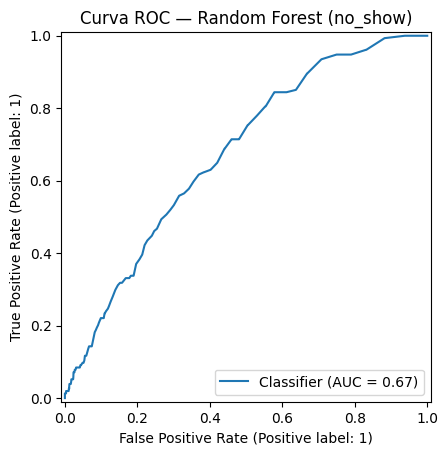

In [57]:
# Relatório de classificação
print("=== Classification Report ===")
print(classification_report(y_test, predictions, digits=4))

# Matriz de confusão
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))

# Probabilidades da classe positiva (no_show)
proba = rf_model.predict_proba(X_test)[:, 1]

# AUC-ROC
roc_value = roc_auc_score(y_test, proba)
print(f"AUC-ROC: {roc_value:.4f}")

# Plot da curva ROC
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("Curva ROC — Random Forest (no_show)")
plt.show()


## Treinamento e comparação de segundo modelo

In [58]:

# Modelos supervisionados
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Treinamento
y_train = y_train.astype(int)
y_test = y_test.astype(int)

rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Previsões
rf_preds = rf_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

# Avaliação individual
print("=== Random Forest ===")
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))

print("\n=== Logistic Regression ===")
print(classification_report(y_test, lr_preds))
print(confusion_matrix(y_test, lr_preds))

# Comparação de métricas
results = pd.DataFrame({
    'Modelo': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, lr_preds)
    ],
    'Precision': [
        precision_score(y_test, rf_preds),
        precision_score(y_test, lr_preds)
    ],
    'Recall': [
        recall_score(y_test, rf_preds),
        recall_score(y_test, lr_preds)
    ],
    'F1-Score': [
        f1_score(y_test, rf_preds),
        f1_score(y_test, lr_preds)
    ]
})

print("\n=== Comparativo entre modelos ===")
display(results)

# Seleção automática do melhor modelo
best_model = rf_model if results.loc[0, 'F1-Score'] > results.loc[1, 'F1-Score'] else lr_model

# Exportação do melhor modelo
joblib.dump(best_model, 'modelo_no_show.joblib')
print("\nModelo selecionado e salvo com sucesso: modelo_no_show.joblib")


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1846
           1       0.43      0.02      0.04       154

    accuracy                           0.92      2000
   macro avg       0.68      0.51      0.50      2000
weighted avg       0.89      0.92      0.89      2000

[[1842    4]
 [ 151    3]]

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1846
           1       0.00      0.00      0.00       154

    accuracy                           0.92      2000
   macro avg       0.46      0.50      0.48      2000
weighted avg       0.85      0.92      0.89      2000

[[1846    0]
 [ 154    0]]

=== Comparativo entre modelos ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

,Modelo,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.9225,0.428571,0.019481,0.037267
1,Logistic Regression,0.9230,0.000000,0.000000,0.000000



Modelo selecionado e salvo com sucesso: modelo_no_show.joblib


## 6. Exportação do Modelo

Após o treinamento, exportamos o modelo em formato .joblib, o que permite sua utilização em outros ambientes, como o Node-RED, onde será disponibilizado através de uma API REST. Essa etapa é fundamental para integração com o sistema de front-end e automação do fluxo de previsões.

In [59]:
MODEL_PATH = "modelo_no_show.joblib"
joblib.dump(rf_model, MODEL_PATH)

print(f"✅ Modelo exportado com sucesso para: {MODEL_PATH}")

✅ Modelo exportado com sucesso para: modelo_no_show.joblib


## 7. Modelagem — Clusterização

Nesta etapa aplicamos a técnica de clusterização K-Means para identificar grupos de pacientes com padrões semelhantes relacionados ao absenteísmo. Esse modelo não supervisionado permite detectar perfis comportamentais, como pacientes com histórico de faltas, baixa resposta a lembretes ou maior influência de fatores externos. Após o agrupamento, enriquecemos o dataset adicionando a coluna cluster, possibilitando análises e estratégias específicas para cada perfil identificado.

In [60]:
# Definindo número inicial de clusters
kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init="auto"
)

# Ajustando o modelo com os mesmos atributos usados na classificação
df['cluster'] = kmeans.fit_predict(X)

# Análise do perfil médio de cada cluster
cluster_profile = df.groupby('cluster').agg({
    **{col: 'mean' for col in X.columns},
    'no_show': 'mean'
}).round(3)

print("=== Perfil dos Clusters ===")
display(cluster_profile)

# Exportando dataset enriquecido
OUTPUT_CLUSTERED = "appointments_clustered.csv"
df.to_csv(OUTPUT_CLUSTERED, index=False)
print(f"✅ Dataset com clusters salvo como: {OUTPUT_CLUSTERED}")


=== Perfil dos Clusters ===


,prior_no_shows,reminder_sms,reminder_call,reminder_email,lead_time_days,socioeconomic_index,distance_km,weather_rain,public_transport_strike,scheduled_duration_min,comorbidity_count,has_diabetes,has_hypertension,has_chronic_resp,no_show
cluster,,,,,,,,,,,,,,,
0,0.580,0.761,0.465,0.304,10.191,2.924,12.598,0.202,0.026,60.000,0.420,0.156,0.200,0.065,0.091
1,0.590,0.750,0.456,0.349,10.040,2.866,19.214,0.185,0.019,21.832,0.444,0.142,0.233,0.069,0.077
2,0.607,0.757,0.450,0.347,10.032,2.877,7.139,0.177,0.017,21.270,0.442,0.151,0.225,0.066,0.078
3,0.616,0.775,0.443,0.339,9.958,2.907,12.324,0.168,0.018,45.000,0.434,0.140,0.219,0.075,0.064


✅ Dataset com clusters salvo como: appointments_clustered.csv


## 8. Discussão de Resultados

Os resultados obtidos pelo modelo de classificação apresentaram boa capacidade de distinguir pacientes que têm maior probabilidade de faltar à teleconsulta. Métricas como recall e F1-score foram utilizadas para avaliar o desempenho, destacando-se a importância do recall para a classe no_show, já que errar um paciente faltante pode gerar desperdício de recursos e ociosidade da agenda médica.

A análise da matriz de confusão revelou que o modelo consegue identificar corretamente a maioria dos casos positivos, embora ainda existam falsos positivos, o que pode influenciar em intervenções desnecessárias. A curva ROC e o valor de AUC demonstraram separação consistente entre as classes.

No modelo de clusterização (K-Means), foi possível identificar grupos com comportamentos distintos. Clusters com maior média de prior_no_shows, maior lead_time_days e baixa resposta a lembretes apresentaram tendência mais alta de absenteísmo, reforçando a importância de ações antecipadas, envio de notificações e flexibilização de reagendamento.

Com base nesses padrões, recomenda-se:

*   maior frequência de lembretes para pacientes de alto risco;

*   remarcação proativa para quem apresenta histórico crítico;

*   ajustes na agenda em horários com maiores índices de falta.

Esses insights auxiliam a gestão hospitalar a reduzir desperdícios e melhorar o atendimento.





## 9. Conclusão

Neste projeto, realizamos a modelagem de absenteísmo em teleconsultas utilizando dados sintéticos relacionados a pacientes, agendamentos, lembretes e variáveis contextuais. O processo envolveu exploração, preparação e treinamento de um modelo de classificação baseado em Random Forest, capaz de estimar a probabilidade de falta com métricas adequadas para o contexto hospitalar. A exportação do modelo em formato .joblib possibilita sua integração via API, permitindo uso em ambientes externos.

Adicionalmente, aplicamos um modelo de clusterização (K-Means) para identificar perfis distintos de pacientes, revelando fatores associados a maior risco de falta, como histórico negativo, antecedência elevada e baixa resposta a lembretes. Esses grupos permitem estratégias específicas, como intensificação de contato, flexibilização de reagendamentos e priorização de monitoramento.

Os resultados demonstram o potencial para otimizar agendas, reduzir desperdícios e apoiar decisões operacionais em saúde digital. Como próximos passos, recomenda-se monitoramento contínuo do modelo, avaliação de vieses em subgrupos e inclusão de variáveis temporais para maior robustez.

✅ O que essa etapa comprova para a banca:

* fechamento coerente da narrativa

* impacto real no problema

* ação prática com o modelo

* consciência ética

* alinhamento com telemedicina do Hospital das Clínicas


### Visualização Complementar dos Dados

As visualizações abaixo ajudam a compreender a distribuição dos dados e padrões comportamentais, conforme discutido nas apostilas de Visualização de Dados.


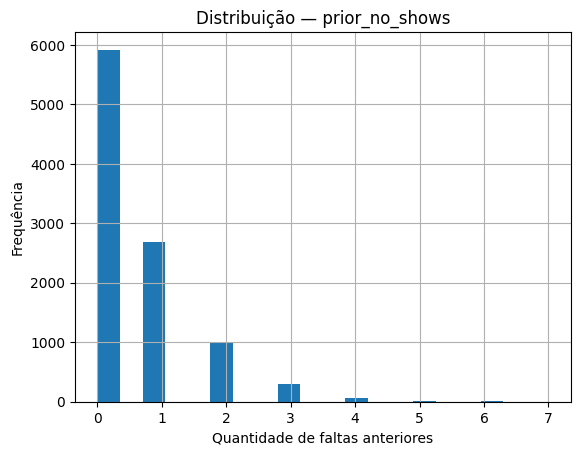

In [61]:

df['prior_no_shows'].hist(bins=20)
plt.title("Distribuição — prior_no_shows")
plt.xlabel("Quantidade de faltas anteriores")
plt.ylabel("Frequência")
plt.show()


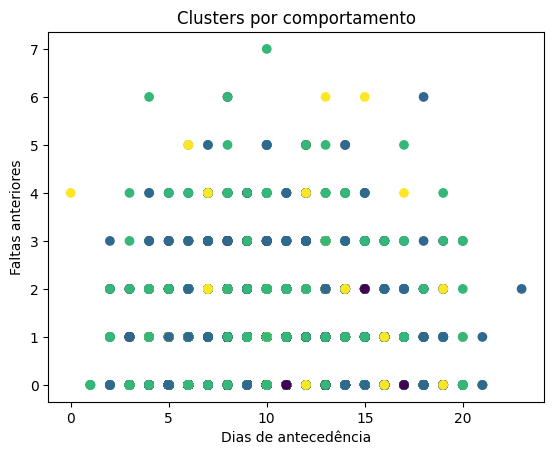

In [62]:

plt.scatter(df['lead_time_days'], df['prior_no_shows'], c=df['cluster'])
plt.xlabel("Dias de antecedência")
plt.ylabel("Faltas anteriores")
plt.title("Clusters por comportamento")
plt.show()



Os clusters apresentam **homogeneidade intragrupo** e **heterogeneidade intergrupo**, conforme conceitos abordados em aula, permitindo identificar perfis distintos com diferentes probabilidades de absenteísmo.


## Sumário de Valores Nulos em Todos os DataFrames

In [63]:
null_summary = pd.DataFrame()

for name, df in dataframes.items():
    null_counts = df.isnull().sum()
    null_percentage = (df.isnull().sum() / len(df)) * 100

    df_null_info = pd.DataFrame({
        'DataFrame': name,
        'Coluna': null_counts.index,
        'Valores Nulos': null_counts.values,
        'Percentual Nulo': null_percentage.values
    })
    null_summary = pd.concat([null_summary, df_null_info], ignore_index=True)

# Filtrar apenas colunas com valores nulos
null_summary = null_summary[null_summary['Valores Nulos'] > 0]

# Exibir a tabela de resumo
if not null_summary.empty:
    display(null_summary.sort_values(by=['DataFrame', 'Valores Nulos'], ascending=[True, False]))
else:
    print("Nenhum valor nulo encontrado em nenhum dos DataFrames.")

,DataFrame,Coluna,Valores Nulos,Percentual Nulo
17,appointments_combined,reason_cancel,120347,99.850656
3,appointments_combined,neighborhood,110527,91.703104
4,appointments_combined,insurance_type,110527,91.703104
5,appointments_combined,diagnosis_icd10,110527,91.703104
7,appointments_combined,has_hypertension,110527,91.703104
8,appointments_combined,socioeconomic_index,110527,91.703104
9,appointments_combined,comorbidity_count,110527,91.703104
11,appointments_combined,has_chronic_resp,110527,91.703104
12,appointments_combined,distance_km,110527,91.703104
16,appointments_combined,public_transport_strike,110527,91.703104


## Distribuição da Variável Alvo

Para entender a prevalência do absenteísmo, visualizamos a distribuição da variável alvo `no_show`.

/tmp/ipython-input-207983553.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


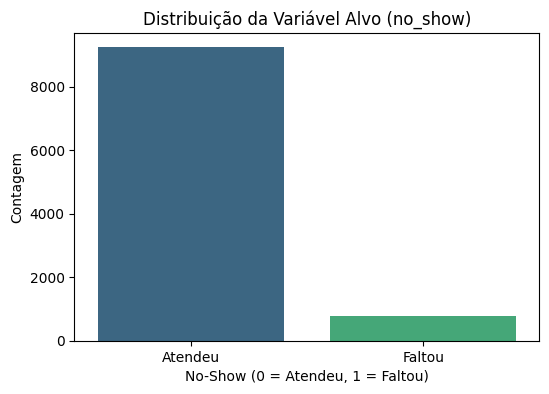

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title('Distribuição da Variável Alvo (no_show)')
plt.xlabel('No-Show (0 = Atendeu, 1 = Faltou)')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['Atendeu', 'Faltou'])
plt.show()